# Modelos de Tasa de Disparo (*Rate Models*)

---
## Configuración

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt  # root-finding algorithm

In [ ]:
# @title Configuración de Figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Funciones de Trazado

def plot_fI(x, f):
  plt.figure(figsize=(6, 4))  # plot the figure
  plt.plot(x, f, 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()


def plot_dr_r(r, drdt, x_fps=None):
  plt.figure()
  plt.plot(r, drdt, 'k')
  plt.plot(r, 0. * r, 'k--')
  if x_fps is not None:
    plt.plot(x_fps, np.zeros_like(x_fps), "ko", ms=12)
  plt.xlabel(r'$r$')
  plt.ylabel(r'$\frac{dr}{dt}$', fontsize=20)
  plt.ylim(-0.1, 0.1)
  plt.show()


def plot_dFdt(x, dFdt):
  plt.figure()
  plt.plot(x, dFdt, 'r')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('dF(x)', fontsize=14)
  plt.show()

## Dinámica de una única población excitadora

Vamos a estudiar numéricamente el modelo de tasa de disparo definido por la ecuación diferencial

$$\dot r = -r + F(wr+I_{ext};a,\theta)$$

Inicializamos parámetros de simulación

In [ ]:
# @markdown *Ejecute esta celda para establecer parámetros predeterminados para un modelo de población excitadora única*


def default_pars_single(**kwargs):
  pars = {}

  # Parámetros excitatorios
  pars['tau'] = 1.     # Escala de tiempo de la población E [ms]
  pars['a'] = 1.2      # Ganancia de la población E
  pars['theta'] = 2.8  # Umbral de la población E

  # Fuerza de conexión
  pars['w'] = 0.  # De E a E, primero lo establecemos en 0

  # Entrada externa
  pars['I_ext'] = 0.

  # parámetros de simulación
  pars['T'] = 20.       # Duración total de la simulación [ms]
  pars['dt'] = .1       # Paso de tiempo de la simulación [ms]
  pars['r_init'] = 0.2  # Valor inicial de E

  # Parámetros externos si los hay
  pars.update(kwargs)

  # Vector de puntos de tiempo discretizados [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars

pars = default_pars_single()
# print(pars)

- `pars = default_pars_single()` para obtener todos los parámetros.
- `pars = default_pars_single(T=T_sim, dt=paso_tiempo)` para establecer un nuevo tiempo de simulación y paso de tiempo.
- Para actualizar un diccionario de parámetros existente, usa `pars['New_para'] = value`

## Definimos la función de activación

\begin{equation}
F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}
\end{equation}

In [ ]:
def F(x, a, theta):
  """
  Función de activación de la población.

  Argumentos:
    x (float): la entrada de la población
    a (float): la ganancia de la función
    theta (float): el umbral de la función

  Devuelve:
    float: la respuesta de activación de la población F(x) para la entrada x
  """
  # Definir la función de transferencia sigmoidea f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


# Establecer parámetros
pars = default_pars_single()  # obtener parámetros predeterminados
x = np.arange(0, 10, .1)      # establecer el rango de entrada

# Calcular la función de transferencia
f = F(x, pars['a'], pars['theta'])

In [ ]:
# @markdown

@widgets.interact(
    a=widgets.FloatSlider(1.5, min=0.3, max=3., step=0.3),
    theta=widgets.FloatSlider(3., min=2., max=4., step=0.2)
)


def interactive_plot_FI(a, theta):
  """
  Función de activación de la población.

   Expectativas:
     a : la ganancia de la función
     theta: el umbral de la función

   Devoluciones:
     trazar la curva F-I con los parámetros dados
  """

  # establecer el rango de entrada
  x = np.arange(0, 10, .1)
  plt.figure()
  plt.plot(x, F(x, a, theta), 'k')
  plt.xlabel('x (a.u.)', fontsize=14)
  plt.ylabel('F(x)', fontsize=14)
  plt.show()

interactive(children=(FloatSlider(value=1.5, description='a', max=3.0, min=0.3, step=0.3), FloatSlider(value=3…

## Simulación del sistema

Debido a que $F(\cdot)$ es una función no lineal, la solución exacta de nuestra ecuación diferencial de actividad poblacional no se puede determinar mediante métodos analíticos. Sin embargo, podemos utilizar métodos numéricos, como el método de Euler, para encontrar la solución (es decir, simular la actividad poblacional).

Vamos a usar el método de Euler como integrador numérico de la siguiente forma

$$r^{t+1} = r^t + \frac{\Delta t}{\tau} \left[-r^t+F(wr^t+I^t;a,\theta)\right]$$

donde $\Delta t$ es el paso temporal que elegimos (mientras más chico, más precisa la simulación)

In [ ]:
# @markdown Ejecute esta celda para habilitar el simulador del modelo de tasa de una sola población: `simulate_single`


def simulate_single(pars):
  """
  Simular una población excitatoria de neuronas

  Argumentos:
    pars   : Diccionario de parámetros

  Devuelve:
    rE     : Actividad de la población excitatoria (array)

  Ejemplo:
    pars = default_pars_single()
    r = simulate_single(pars)
  """

  # Establecer parámetros
  tau, a, theta = pars['tau'], pars['a'], pars['theta']
  w = pars['w']
  I_ext = pars['I_ext']
  r_init = pars['r_init']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Inicializar actividad
  r = np.zeros(Lt)
  r[0] = r_init
  I_ext = I_ext * np.ones(Lt)

  # Actualizar la actividad de E
  for k in range(Lt - 1):
      dr = dt / tau * (-r[k] + F(w * r[k] + I_ext[k], a, theta))
      r[k+1] = r[k] + dr

  return r

---
## Buscamos y visualizamos puntos fijos


Cuando no es posible encontrar analíticamente la solución para la Ecuación (3), se puede adoptar un enfoque gráfico. Con ese fin, es útil trazar $\displaystyle{\frac{dr}{dt}}$ en función de $r$. Los valores de $r$ para los cuales la función trazada cruza cero en el eje y corresponden a puntos fijos.

Aquí, por ejemplo, establezcamos $w=5.0$ y $I^{\text{ext}}=0.5$. De la ecuación (3), se puede obtener

\begin{equation}
\frac{dr}{dt} = [-r + F(w\cdot r + I^{\text{ext}})]\,/\,\tau
\end{equation}

Luego, trace el $dr/dt$ en función de $r$ y verifique la presencia de puntos fijos.

#### Búsqueda numérica

Necesitamos especificar valores iniciales ($r_{\text{guess}}$) para que comience el algoritmo de búsqueda de raíces (conviene graficar previamente la función para dar condiciones iniciales aceptables) .

Las funciones auxiliares a usar son:

- `my_fp_single(r_guess, **pars)` utiliza un algoritmo de búsqueda de raíces para localizar un punto fijo cerca de un valor inicial determinado
- `check_fp_single(x_fp, **pars)` verifica que los valores de $r_{\rm fp}$ para los cuales $\displaystyle{\frac{dr}{dt}} = 0$ son los verdaderos puntos fijos
- `my_fp_finder(r_guess_vector, **pars)` acepta una matriz de valores iniciales y encuentra el mismo número de puntos fijos, usando las dos funciones anteriores

In [ ]:
# @title Funciones auxiliares

def my_fp_single(r_guess, a, theta, w, I_ext, **otros_pars):
  """
  Calcular el punto fijo a través de drE/dt=0

  Argumentos:
    r_guess  : Valor inicial utilizado para la función scipy.optimize
    a, theta, w, I_ext : parámetros de simulación

  Devuelve:
    x_fp    : valor del punto fijo
  """
  # definir la mano derecha de la dinámica de E
  def my_WCr(x):
    r = x
    drdt = (-r + F(w * r + I_ext, a, theta))
    y = np.array(drdt)

    return y

  x0 = np.array(r_guess)
  x_fp = opt.root(my_WCr, x0).x.item()

  return x_fp


def check_fp_single(x_fp, a, theta, w, I_ext, mytol=1e-4, **otros_pars):
  """
   Verificar |dr/dt| < mytol

  Argumentos:
    fp      : valor del punto fijo
    a, theta, w, I_ext: parámetros de simulación
    mytol   : tolerancia, por defecto 10^{-4}

  Devuelve :
    Si es un punto fijo correcto: Verdadero/Falso
  """
  # calcular la Ecuación(3)
  y = x_fp - F(w * x_fp + I_ext, a, theta)

  # Aquí establecemos la tolerancia como 10^{-4}
  return np.abs(y) < mytol


def my_fp_finder(pars, r_guess_vector, mytol=1e-4):
  """
  Calcular los puntos fijos a través de drE/dt=0

  Argumentos:
    pars    : Diccionario de parámetros
    r_guess_vector  : Valores iniciales utilizados para la función scipy.optimize
    mytol   : tolerancia para verificar el punto fijo, por defecto 10^{-4}

  Devuelve:
    x_fps   : valores de los puntos fijos

  """
  x_fps = []
  correct_fps = []
  for r_guess in r_guess_vector:
    x_fp = my_fp_single(r_guess, **pars)
    if check_fp_single(x_fp, **pars, mytol=mytol):
      x_fps.append(x_fp)

  return x_fps

#### Barrido de parámetros

In [ ]:
# @title Widget

@widgets.interact(
    w=widgets.FloatSlider(5., min=1., max=7., step=0.2),
    I_ext=widgets.FloatSlider(.5, min=0., max=3., step=0.1)
)


def plot_intersection_single(w, I_ext):
  # establece tus parámetros
  pars = default_pars_single(w=w, I_ext=I_ext)

  # encontrar puntos fijos
  r_init_vector = [0, .4, .9]
  x_fps = my_fp_finder(pars, r_init_vector)

  # trama
  r = np.linspace(0, 1., 1000)
  drdt = (-r + F(w * r + I_ext, pars['a'], pars['theta'])) / pars['tau']

  plot_dr_r(r, drdt, x_fps)

interactive(children=(FloatSlider(value=5.0, description='w', max=7.0, min=1.0, step=0.2), FloatSlider(value=0…

## Trazado de trayectorias: convergencia a punto fijo

Examinemos la relación entre la actividad de la población a lo largo del tiempo y los puntos fijos.

Primero establezcamos $w=5.0$ y $I_{\text{ext}}=0.5$, e investiguemos la dinámica de $r(t)$ comenzando con diferentes valores iniciales $r(0) \equiv r_{ \text{inicio}}$ (pueden probar otros valores para ver la dinámica en la bifurcación).

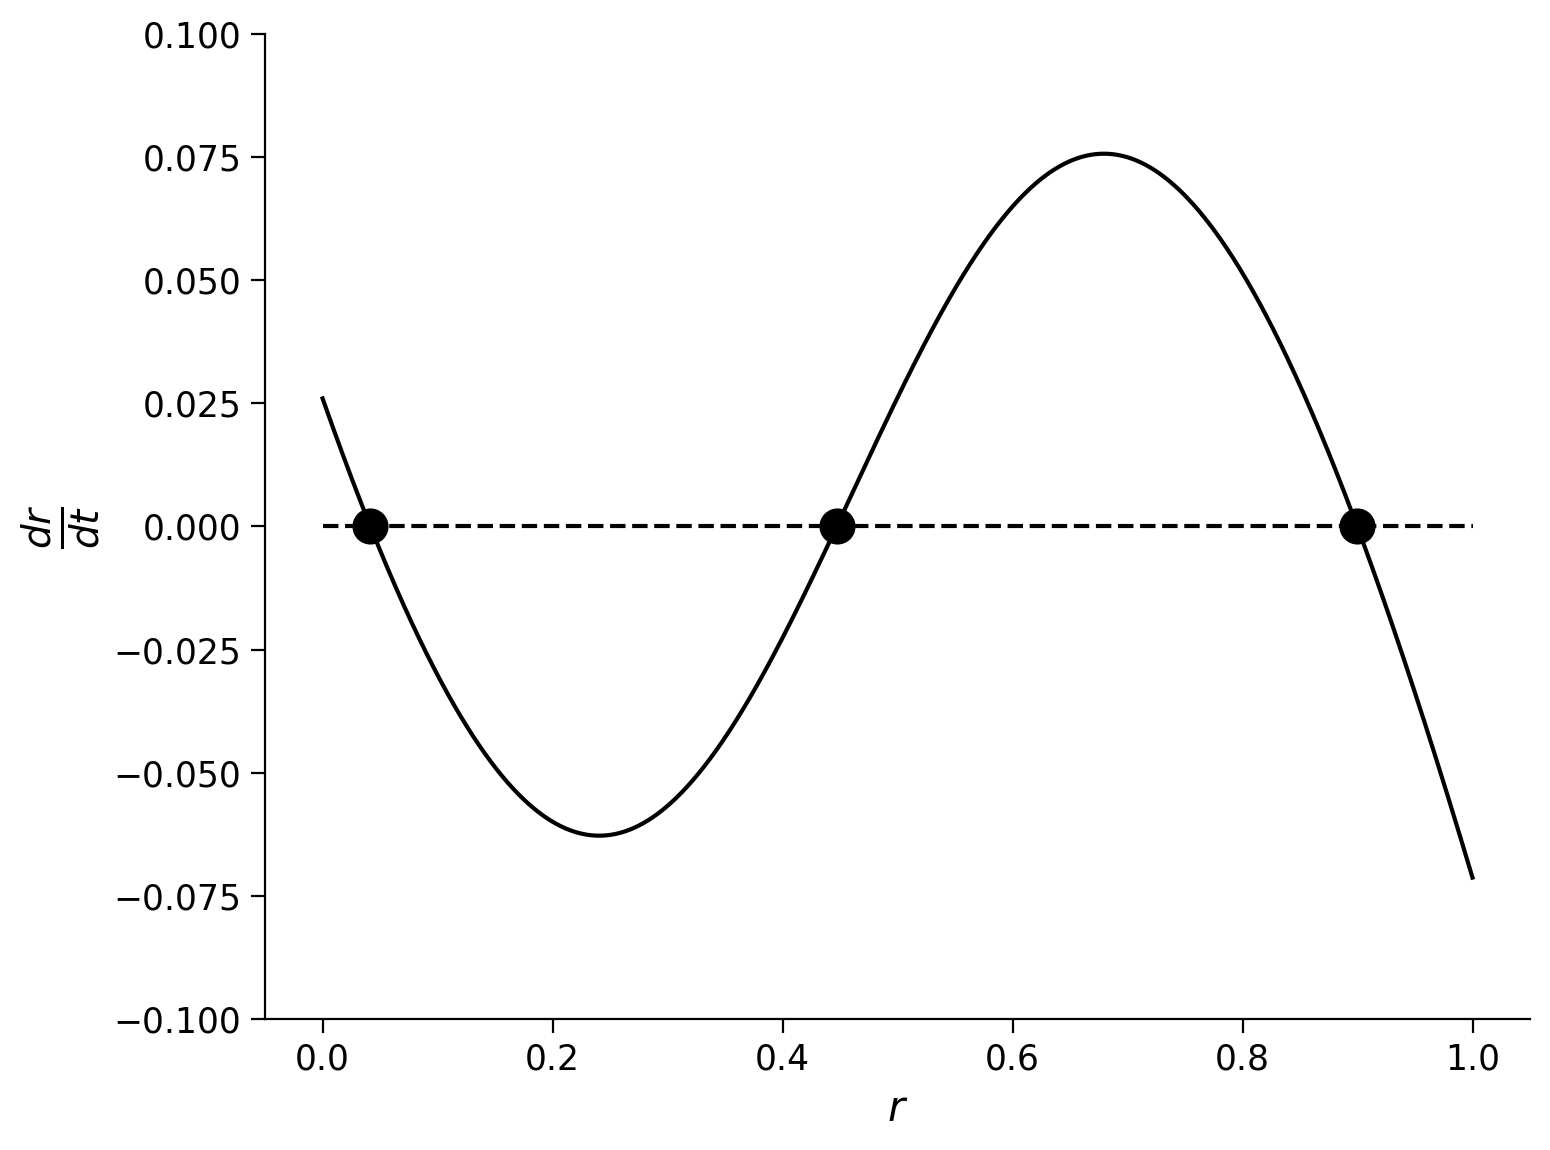

In [ ]:
# @title Visualizar dr/dt

def plot_intersection_single(w, I_ext):
  # establece tus parámetros
  pars = default_pars_single(w=w, I_ext=I_ext)

  # encontrar puntos fijos
  r_init_vector = [0, .4, .9]
  x_fps = my_fp_finder(pars, r_init_vector)

  # trama
  r = np.linspace(0, 1., 1000)
  drdt = (-r + F(w * r + I_ext, pars['a'], pars['theta'])) / pars['tau']

  plot_dr_r(r, drdt, x_fps)


plot_intersection_single(w = 5.0, I_ext = 0.5)

Tracemos las trayectorias de $r(t)$ con $r_{\text{init}} = 0.0, 0.1, 0.2,..., 0.9$.

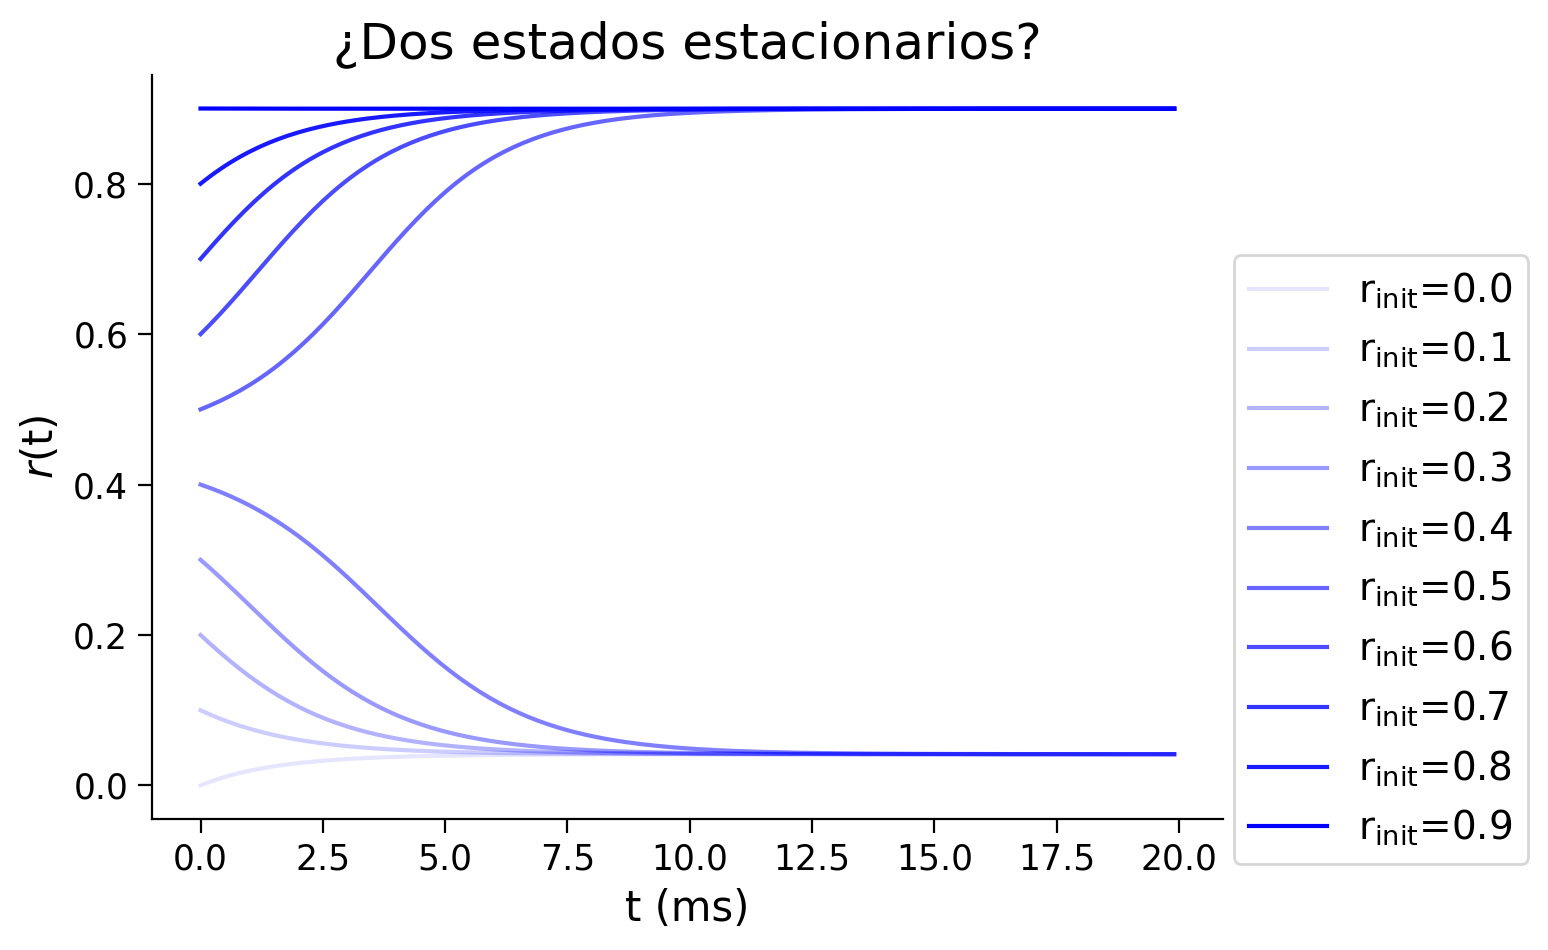

In [ ]:
# @markdown ¡Ejecuta esta celda para ver las trayectorias!

pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

plt.figure(figsize=(8, 5))
for ie in range(10):
  pars['r_init'] = 0.1 * ie  # establecer el valor inicial
  r = simulate_single(pars)  # ejecutar la simulación

  # trazar la actividad con la inicial dada
  plt.plot(pars['range_t'], r, 'b', alpha=0.1 + 0.1 * ie,
           label=r'r$_{\mathrm{init}}$=%.1f' % (0.1 * ie))

plt.xlabel('t (ms)')
plt.title('¿Dos estados estacionarios?')
plt.ylabel(r'$r$(t)')
plt.legend(loc=[1.01, -0.06], fontsize=14)
plt.show()

In [ ]:
# @title Busquemos numéricamente los valores de estos puntos fijos

# Suposiciones iniciales para puntos fijos
r_guess_vector = [0, .4, .9]

# Encuentra el punto fijo numéricamente
x_fps = my_fp_finder(pars, r_guess_vector)

print(f'Nuestros puntos fijos son {x_fps}')

Nuestros puntos fijos son [0.04153669901331739, 0.4471192240898344, 0.8997171538560865]


Podemos simular la trayectoria si comenzamos en el punto fijo inestable: permanece en ese punto fijo (la línea roja de abajo).

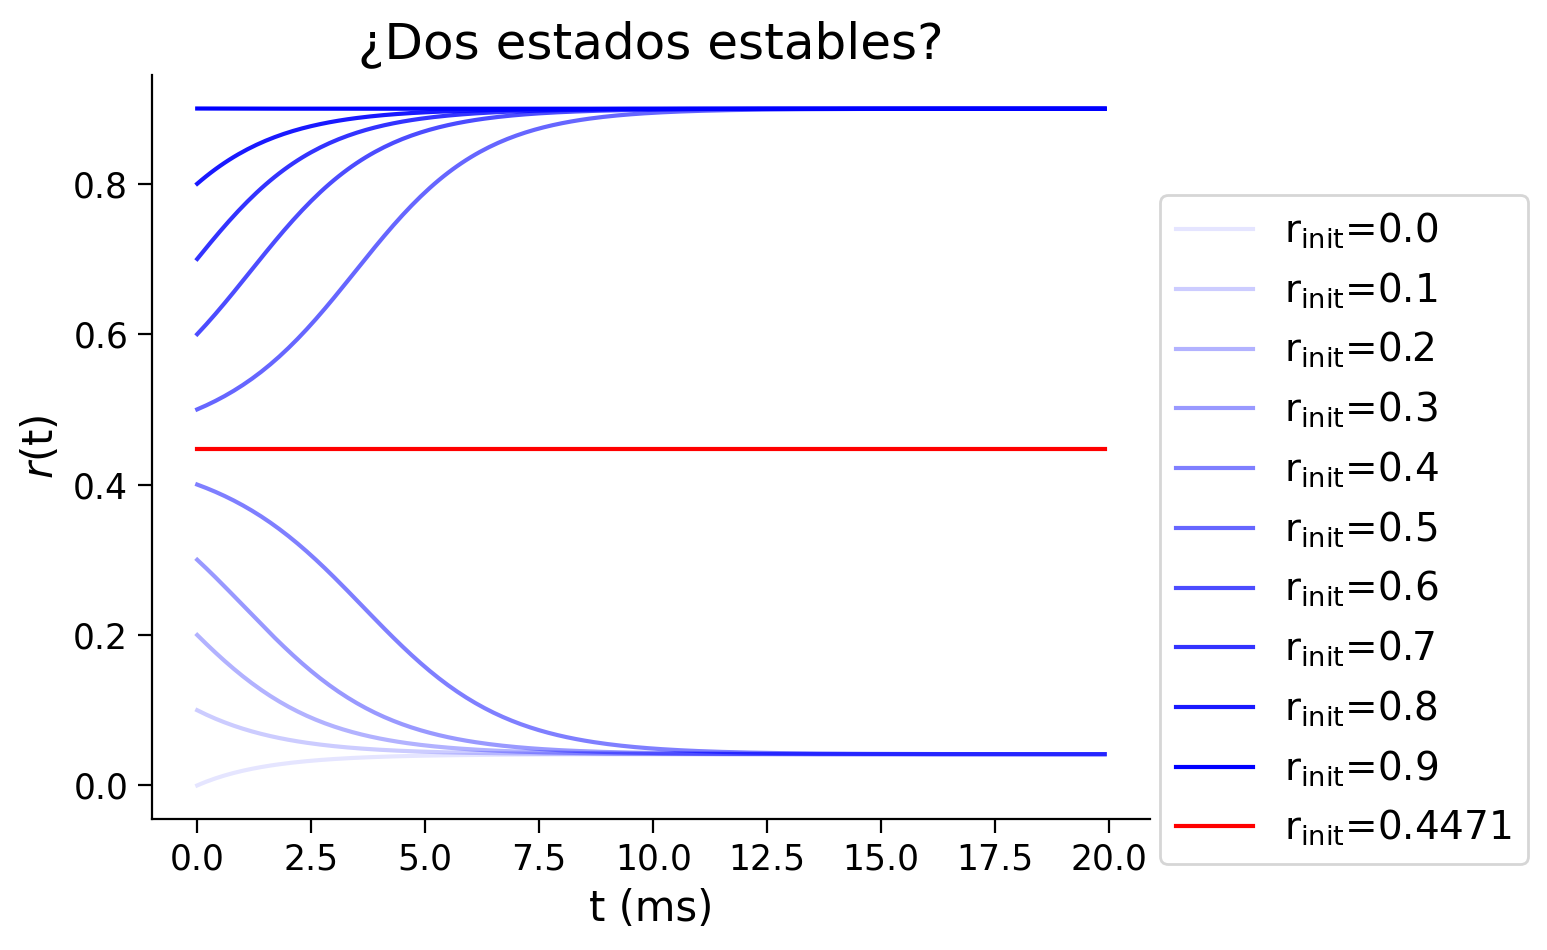

In [ ]:
# @markdown Ejecute para visualizar la trayectoria que comienza en el punto fijo inestable
pars = default_pars_single()
pars['w'] = 5.0
pars['I_ext'] = 0.5

plt.figure(figsize=(8, 5))
for ie in range(10):
  pars['r_init'] = 0.1 * ie  # establecer el valor inicial
  r = simulate_single(pars)  # ejecutar la simulación

  # graficar la actividad con el valor inicial dado
  plt.plot(pars['range_t'], r, 'b', alpha=0.1 + 0.1 * ie,
           label=r'r$_{\mathrm{init}}$=%.1f' % (0.1 * ie))

pars['r_init'] = x_fps[1]  # establecer el valor inicial
r = simulate_single(pars)  # ejecutar la simulación

# graficar la actividad con el valor inicial dado
plt.plot(pars['range_t'], r, 'r', alpha=0.1 + 0.1 * ie,
          label=r'r$_{\mathrm{init}}$=%.4f' % (x_fps[1]))

plt.xlabel('t (ms)')
plt.title('¿Dos estados estables?')
plt.ylabel(r'$r$(t)')
plt.legend(loc=[1.01, -0.06], fontsize=14)
plt.show()

## Un *input* ruidoso impulsa la transición entre dos estados estables

Vamos a modelar un proceso de Ornstein-Uhlenbeck (OU). Éste generalmente se usa para generar una entrada ruidosa en la neurona. La entrada de OU $\eta(t)$ es la siguiente:

\begin{equation}
\tau_\eta \frac{d}{dt}\eta(t) = -\eta (t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t)
\end{equation}

donde $\xi(t)$ es una variable aleatoria gaussiana de media nula y desviación estándar 1.

Con la siguiente función `my_OU(pars, sig, myseed=False)` vamos a generar un proceso de OU.

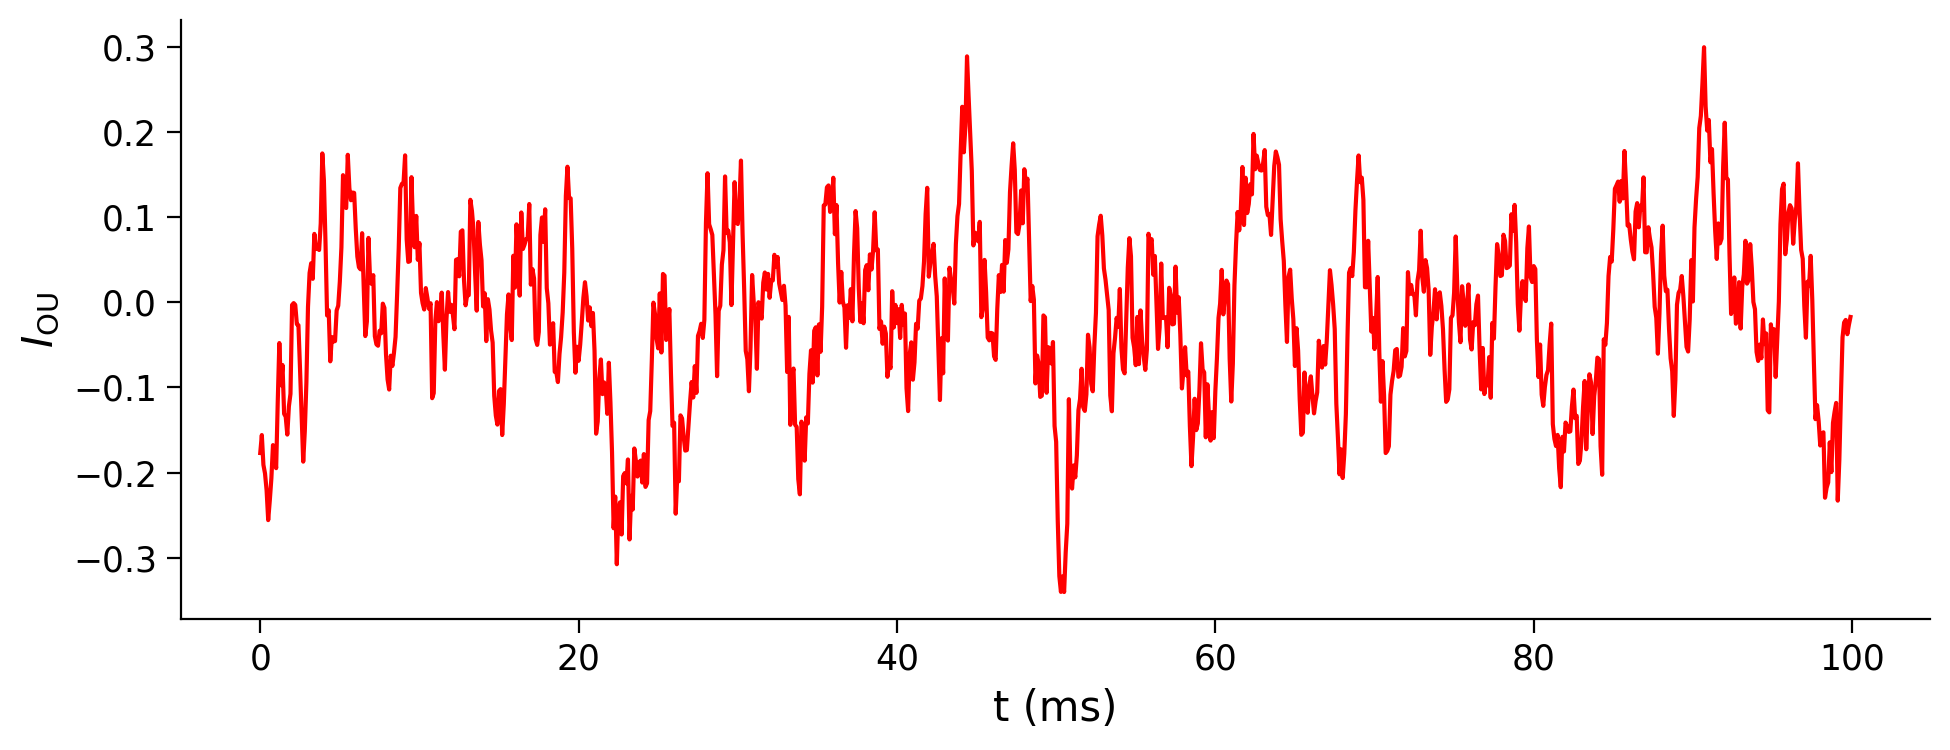

In [ ]:
# @title Visualizar el proceso OU


def my_OU(pars, sig, myseed=False):
  """
  Una función que genera el proceso de Ornstein-Uhlenbeck

  Argumentos:
    pars       : diccionario de parámetros
    sig        : amplitud del ruido
    myseed     : semilla aleatoria. int o booleano

  Devuelve:
    I          : corriente de entrada de Ornstein-Uhlenbeck
  """

  # Recuperar parámetros de simulación
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # establecer semilla aleatoria
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # Inicializar
  ruido = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = ruido[0] * sig

  # generar OU
  for it in range(Lt - 1):
    I_ou[it + 1] = (I_ou[it]
                    + dt / tau_ou * (0. - I_ou[it])
                    + np.sqrt(2 * dt / tau_ou) * sig * ruido[it + 1])

  return I_ou


pars = default_pars_single(T=100)
pars['tau_ou'] = 1.  # [ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=2020)
plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], I_ou, 'r')
plt.xlabel('t (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()

En presencia de dos o más puntos fijos, las entradas ruidosas pueden provocar una transición entre los puntos fijos. Aquí, estimulamos una población E durante 1000 ms aplicando entradas OU.

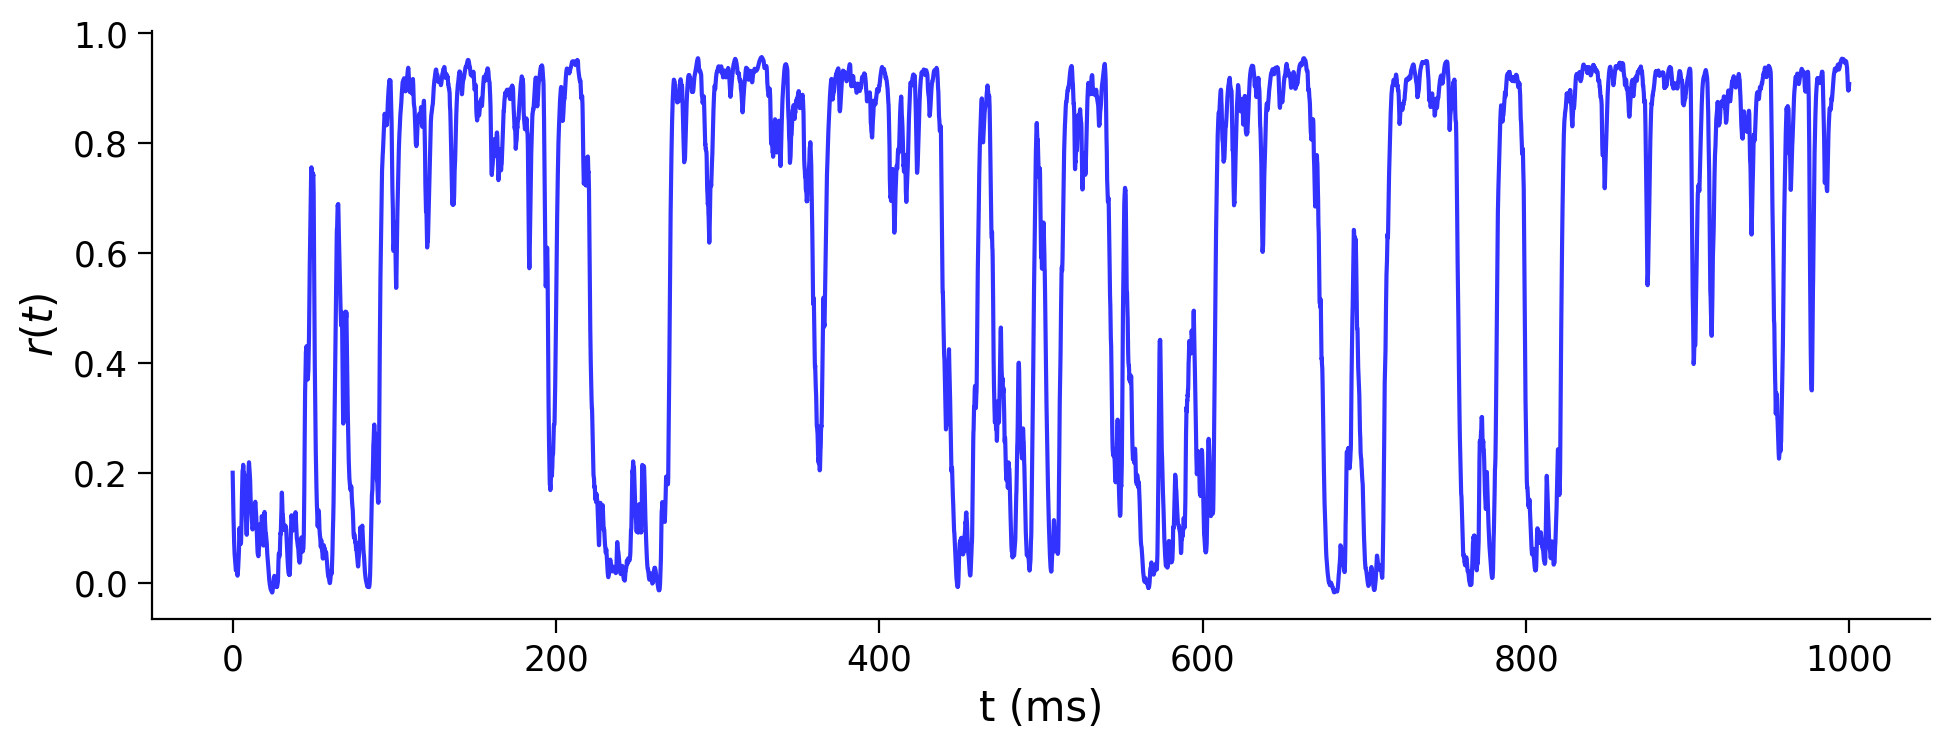

In [ ]:
# @markdown Ejecute esta celda para simular la población E con entradas de OU
pars = default_pars_single(T=1000)
pars['w'] = 5.0
sig_ou = 0.7
pars['tau_ou'] = 1.  # [ms]
pars['I_ext'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)

r = simulate_single(pars)

plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], r, 'b', alpha=0.8)
plt.xlabel('t (ms)')
plt.ylabel(r'$r(t)$')
plt.show()

Podemos jugar con el tiempo característico y la desviación del ruido para ver cómo afecta la transición entre estados

In [ ]:
# @title Widget

@widgets.interact(
    sigma=widgets.FloatSlider(0., min=0., max=4., step=0.2),
    tau=widgets.FloatSlider(1., min=.5, max=2., step=0.1)
)


def plot_intersection_single(sigma,tau):
  # establece tus parámetros
  pars['w'] = 5.0
  sig_ou = sigma
  pars['tau_ou'] = tau  # [ms]
  pars['I_ext'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)
  sig_ou = sigma
  r = simulate_single(pars)

  plt.figure(figsize=(10, 4))
  plt.plot(pars['range_t'], r, 'b', alpha=0.8)
  plt.xlabel('t (ms)')
  plt.ylabel(r'$r(t)$')
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='sigma', max=4.0, step=0.2), FloatSlider(value=1.0, d…